# Customer Classification Project

## Overview
This project focuses on predicting customer categories such as **upsell**, **retain**, and **monitor** using machine learning models. The implementation uses **XGBoost** for classification, and provides evaluation metrics for comparison.

## Libraries Used
- **pandas, numpy**: Data manipulation and preprocessing  
- **matplotlib, seaborn**: Data visualization  
- **scikit-learn**: Model building, evaluation, and preprocessing  
- **xgboost**: Gradient boosting algorithm for classification  
- **gradio**: Interactive user interface for deployment  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,roc_curve
import gradio as gr
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing Dataset
import os
path="/content/drive/MyDrive/dataset"
files=os.listdir(path)
file_path2=os.path.join(path,"CDR-Call-Details.csv")

In [ ]:
# Creating DataFrame
import pandas as pd
df=pd.read_csv(file_path2)
print("Shape: ",df.shape)
df.head()

Shape:  (101174, 17)


,Phone Number,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,382-4657,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,371-7191,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,358-1921,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,375-9999,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,330-6626,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Data Cleaning: Removing Duplicates

To ensure data quality, duplicate rows in the dataset were removed. This helps prevent biased model training and redundant information.


In [ ]:
df.drop_duplicates(keep='first', inplace=True)
print("Shape after dropping duplicate rows:", df.shape)

Shape after dropping duplicate rows: (60445, 17)


## Data Aggregation by Customer

Since multiple records may exist for the same customer (identified by **Phone Number**), the dataset was aggregated to create one record per customer. This ensures that customer-level behavior is accurately captured.


In [ ]:
agg_dict = {
    "Account Length": "max",
    "VMail Message": "max",
    "Day Mins": "sum",
    "Day Calls": "sum",
    "Day Charge": "sum",
    "Eve Mins": "sum",
    "Eve Calls": "sum",
    "Eve Charge": "sum",
    "Night Mins": "sum",
    "Night Calls": "sum",
    "Night Charge": "sum",
    "Intl Mins": "sum",
    "Intl Calls": "sum",
    "Intl Charge": "sum",
    "CustServ Calls": "sum",
    "Churn": "max"
}

df_cleaned = df.groupby("Phone Number", as_index=False).agg(agg_dict)

In [ ]:
df.shape

(60445, 17)

## Feature Engineering

To enhance the predictive power of the dataset, new features were engineered from existing variables:

1. **Total Usage Features**  
   - **Total Minutes**: Sum of all minutes used across Day, Evening, Night, and International calls.  
   - **Total Calls**: Sum of all calls made across Day, Evening, Night, and International categories.  

2. **Average Calls per Day**  
   - Represents how frequently a customer makes calls relative to the length of their account.  
   - Calculated as the ratio of **Total Calls** to **Account Length**.  

3. **Service Interaction Flag**  
   - A binary indicator to capture customers with high customer service interactions.  
   - Assigned a value of **1** if the customer contacted customer service more than three times, else **0**.  

### Rationale
- Aggregated features like **Total Usage** provide a comprehensive view of customer activity.  
- **Average Calls per Day** normalizes call activity over account lifespan, making comparisons fairer between long-term and short-term customers.  
- The **High Service Caller** flag may signal dissatisfaction, which could be a strong predictor of churn.  

### Outcome
The dataset now contains additional engineered features that better represent customer behavior patterns and may improve model performance.


In [ ]:
#  Feature Engineering DONE


 # 1. Total Usage Features
df_cleaned["Total Mins"] = df_cleaned["Day Mins"] + df_cleaned["Eve Mins"] + df_cleaned["Night Mins"] + df_cleaned["Intl Mins"]
df_cleaned["Total Calls"] = df_cleaned["Day Calls"] + df_cleaned["Eve Calls"] + df_cleaned["Night Calls"] + df_cleaned["Intl Calls"]
# 2. Average Calls per Day of account life

df_cleaned["Avg Calls per Day"] = df_cleaned["Total Calls"] / df_cleaned["Account Length"]

 # 3. Service Interaction Flag
df_cleaned["HighServiceCaller"] = (df_cleaned["CustServ Calls"] > 3).astype(int)

 #  Preview new dataset
print("New Features Added ")
display(df_cleaned.head())

New Features Added 


,Phone Number,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,...,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn,Total Mins,Total Calls,Avg Calls per Day,HighServiceCaller
0,327-1058,112,0,166.0,79,28.22,74.6,100,6.34,247.9,...,11.16,6.3,7,1.70,0,False,494.8,260,2.321429,0
1,327-1319,22,23,182.1,94,30.96,164.6,59,13.99,128.8,...,5.80,12.7,4,3.43,3,False,488.2,259,11.772727,0
2,327-3053,87,0,110.9,91,18.85,158.5,115,13.47,207.5,...,9.34,6.2,5,1.67,1,False,483.1,342,3.931034,0
3,327-3587,103,36,87.2,92,14.82,169.3,110,14.39,166.7,...,7.50,10.9,5,2.94,6,True,434.1,287,2.786408,1
4,327-3850,91,0,149.0,115,25.33,245.3,105,20.85,260.0,...,11.70,8.3,3,2.24,0,False,662.6,317,3.483516,0


In [ ]:
df_cleaned.head()

,Phone Number,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,...,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn,Total Mins,Total Calls,Avg Calls per Day,HighServiceCaller
0,327-1058,112,0,166.0,79,28.22,74.6,100,6.34,247.9,...,11.16,6.3,7,1.70,0,False,494.8,260,2.321429,0
1,327-1319,22,23,182.1,94,30.96,164.6,59,13.99,128.8,...,5.80,12.7,4,3.43,3,False,488.2,259,11.772727,0
2,327-3053,87,0,110.9,91,18.85,158.5,115,13.47,207.5,...,9.34,6.2,5,1.67,1,False,483.1,342,3.931034,0
3,327-3587,103,36,87.2,92,14.82,169.3,110,14.39,166.7,...,7.50,10.9,5,2.94,6,True,434.1,287,2.786408,1
4,327-3850,91,0,149.0,115,25.33,245.3,105,20.85,260.0,...,11.70,8.3,3,2.24,0,False,662.6,317,3.483516,0


In [ ]:
df_cleaned.shape

(7467, 21)

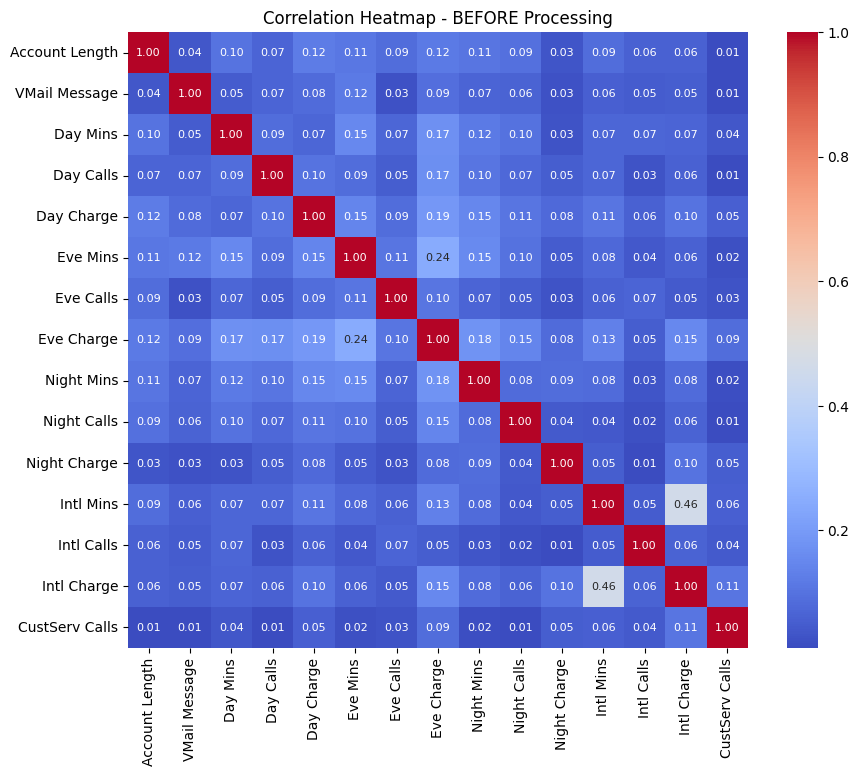

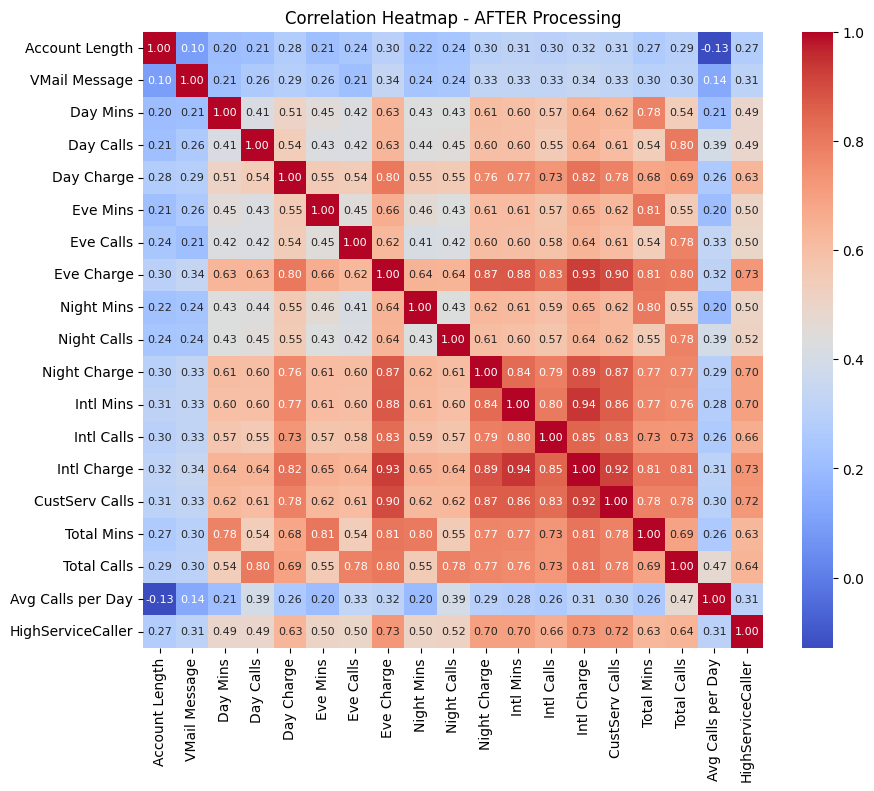

In [ ]:
# Correlation Heatmap: BEFORE vs AFTER
def plot_corr(df, title):
    num_cols = df.select_dtypes(include=[np.number])
    corr = num_cols.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", annot_kws={"size":8})
    plt.title(title)
    plt.show()

plot_corr(df, "Correlation Heatmap - BEFORE Processing")
plot_corr(df_cleaned, "Correlation Heatmap - AFTER Processing")

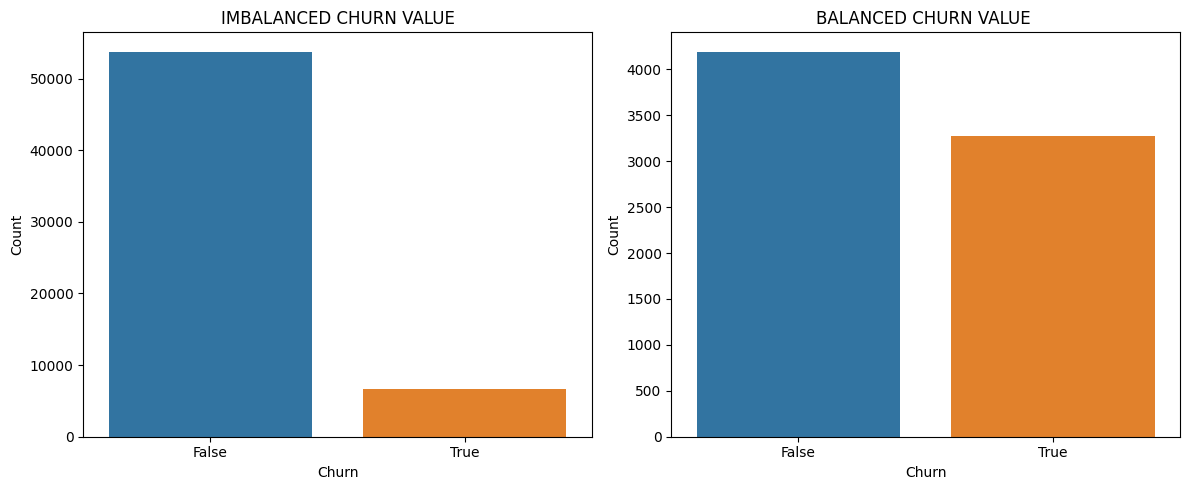

In [ ]:
# Churn Distribution: Before vs After
fig, axes = plt.subplots(1, 2, figsize=(12,5))
# BEFORE (already True/False but reindex to ensure both)
before_counts = df["Churn"].replace({0: False, 1: True}).value_counts().reindex([False, True], fill_value=0)
sns.barplot(
    x=before_counts.index.astype(str),
    y=before_counts.values,
    palette='tab10',
    ax=axes[0]
)
axes[0].set_title("IMBALANCED CHURN VALUE")
axes[0].set_xlabel("Churn")
axes[0].set_ylabel("Count")

# AFTER (convert 0/1 → False/True)
after_counts = df_cleaned["Churn"].replace({0: False, 1: True}).value_counts().reindex([False, True], fill_value=0)
sns.barplot(
    x=after_counts.index.astype(str),
    y=after_counts.values,
    palette='tab10',
    ax=axes[1]
)
axes[1].set_title("BALANCED CHURN VALUE ")
axes[1].set_xlabel("Churn")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
# Feature adjustment to fit model
df_cleaned['Churn'] = df_cleaned['Churn'].astype(int)
print("Churn column converted to integers.")
df_cleaned = df_cleaned.drop(columns=["Phone Number"], errors="ignore")
print("Phone Number column dropped.")

df_cleaned.head()
df_cleaned.shape

Churn column converted to integers.
Phone Number column dropped.


(7467, 20)

## Model Training and Evaluation with XGBoost

### 1. Feature and Target Separation
- The dataset was divided into **features (X)** and **target (y)**.  
- **Target Variable**: `Churn` (binary classification: churned or not churned).  
- **Features**: All other customer-level attributes derived from the cleaned dataset.  

### 2. Train-Test Split
- The dataset was split into **80% training data** and **20% testing data**.  
- A fixed random seed was used for reproducibility.  

### 3. Model Evaluation Function
- A custom evaluation function was defined to compute:  
  - **Accuracy**: Overall correctness of predictions.  
  - **Precision**: Ability to correctly identify churners among predicted churns.  
  - **Recall**: Ability to capture actual churners.  
  - **F1-Score**: Harmonic mean of precision and recall, balancing both metrics.  

### 4. XGBoost Model Setup
- **DMatrix** objects were created for optimized memory and computation.  
- **Hyperparameters**:  
  - `objective = binary:logistic` → Binary classification task.  
  - `eval_metric = logloss` → Loss function used for evaluation.  
  - `eta = 0.05` → Learning rate (controls the contribution of each tree).  
  - `max_depth = 6` → Maximum depth of each decision tree.  
  - `subsample = 0.8` → Randomly samples 80% of training data for each iteration (reduces overfitting).  
  - `colsample_bytree = 0.8` → Randomly samples 80% of features for each tree.  
  - `seed = 42` → Ensures reproducibility.  

### 5. Early Stopping
- **Early stopping** was implemented with a patience of 50 rounds.  
- If the evaluation metric does not improve for 50 consecutive iterations, training stops early to prevent overfitting.  

### 6. Predictions and Evaluation
- Model predictions were generated on the test set.  
- A threshold of **0.40** (instead of default 0.50) was applied to convert probabilities into binary predictions.  
- The custom evaluation function was used to print performance metrics for the XGBoost model.  

### Outcome
- The trained XGBoost model provides metrics such as accuracy, precision, recall, and F1-score to assess churn prediction performance.  
- The threshold adjustment (0.40) allows for better recall of churners, which is often more critical in customer retention tasks.  


# XG BOOST using Cleaned data


In [ ]:
# Features & target
X = df_cleaned.drop("Churn", axis=1)
y = df_cleaned["Churn"]

# Drop 'Phone Number' column as it is not a numerical feature
X = X.drop("Phone Number", axis=1, errors="ignore")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def evaluate_model(model_name, y_true, y_pred):
    """Evaluates a model and prints the metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"--- {model_name} Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * (len(model_name) + 10))

# Prepare DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

evals = [(dtrain, "train"), (dtest, "eval")]
evals_result = {} # Dictionary to store evaluation results

# Train XGBoost with early stopping
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False,
    evals_result=evals_result # Capture evaluation results here
)

# Predictions for both train and test
y_train_pred = (xgb_model.predict(dtrain) > 0.40).astype(int)
y_test_pred = (xgb_model.predict(dtest) > 0.40).astype(int)

# Evaluate both
evaluate_model("XGBoost - Train", y_train, y_train_pred)
evaluate_model("XGBoost - Test", y_test, y_test_pred)

--- XGBoost - Train Metrics ---
Accuracy: 0.8197
Precision: 0.7187
Recall: 0.9611
F1 Score: 0.8224
-------------------------
--- XGBoost - Test Metrics ---
Accuracy: 0.8005
Precision: 0.7182
Recall: 0.9234
F1 Score: 0.8080
------------------------


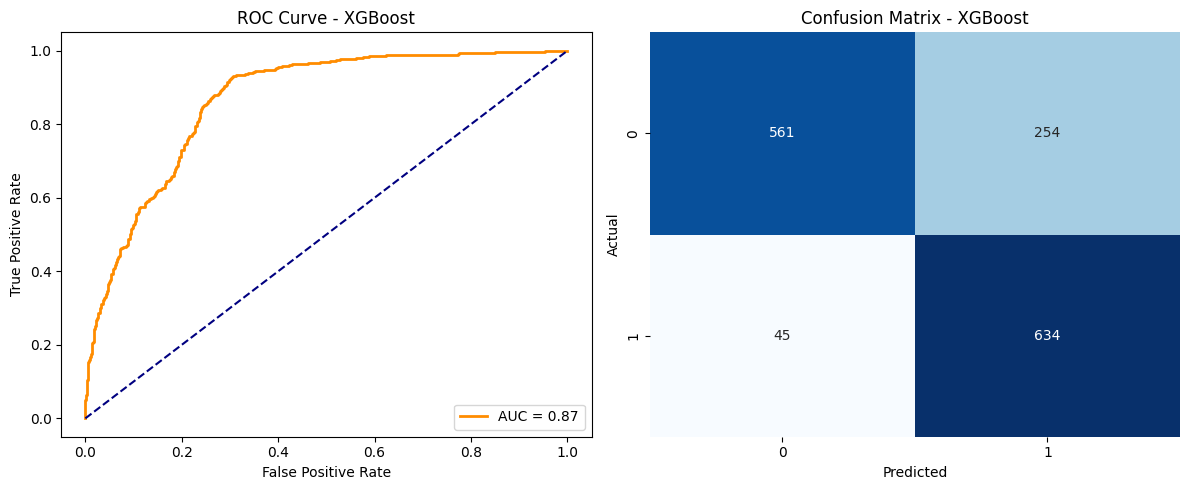

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ROC Curve & Confusion Matrix for XGBoost
y_test_proba = xgb_model.predict(dtest)  # raw probabilities
y_test_pred = (y_test_proba > 0.35).astype(int)

plt.figure(figsize=(12,5))

# 1. ROC Curve
plt.subplot(1,2,1)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")

# 2. Confusion Matrix
plt.subplot(1,2,2)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")

plt.tight_layout()
plt.show()


# LightGBM using Cleaned Data

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Features & Target
X = df_cleaned.drop("Churn", axis=1)
y = df_cleaned["Churn"]

# Drop 'Phone Number' if present
X = X.drop("Phone Number", axis=1, errors="ignore")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# LightGBM Dataset
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# LightGBM Parameters
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "seed": 42
}

# Train LightGBM with Early Stopping
callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]

lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=5000,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=["train", "eval"],
    callbacks=callbacks
)

# Predictions for Train & Test
y_train_pred = (lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration) > 0.5).astype(int)
y_test_pred = (lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration) > 0.5).astype(int)

# Evaluation Function
def evaluate_model(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"--- {model_name} Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * (len(model_name) + 10))

# Evaluate Both
evaluate_model("LightGBM - Train", y_train, y_train_pred)
evaluate_model("LightGBM - Test", y_test, y_test_pred)


--- LightGBM - Train Metrics ---
Accuracy: 0.8463
Precision: 0.7615
Recall: 0.9410
F1 Score: 0.8418
--------------------------
--- LightGBM - Test Metrics ---
Accuracy: 0.7945
Precision: 0.7225
Recall: 0.8895
F1 Score: 0.7974
-------------------------


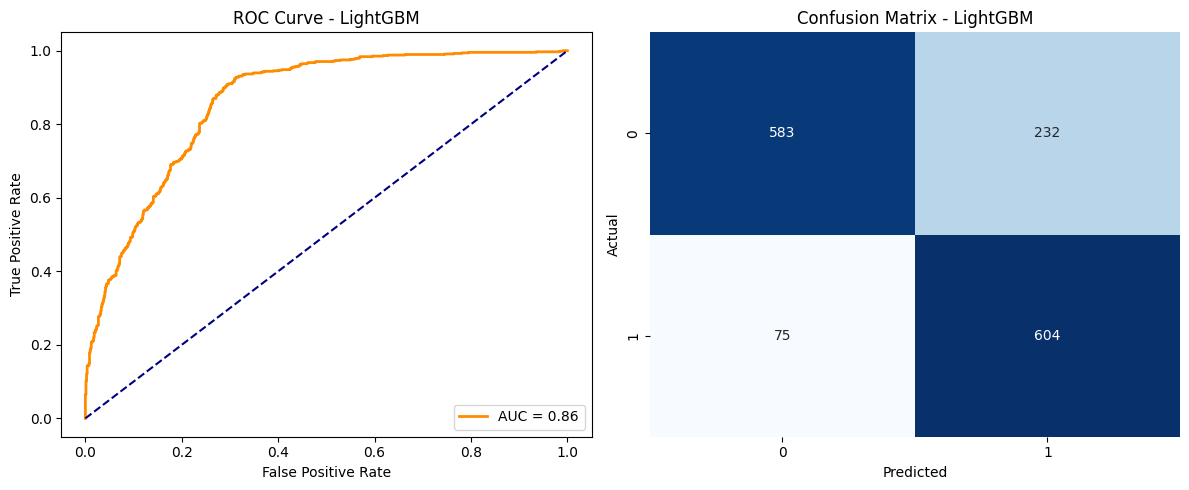

In [ ]:
# ROC Curve & Confusion Matrix for LightGBM

from sklearn.metrics import roc_curve, auc, confusion_matrix
y_test_proba = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_test_pred = (y_test_proba > 0.5).astype(int)

plt.figure(figsize=(12,5))

# 1. ROC Curve
plt.subplot(1,2,1)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend(loc="lower right")

# 2. Confusion Matrix
plt.subplot(1,2,2)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LightGBM")

plt.tight_layout()
plt.show()


# ADA BOOST using Cleaned Data

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Features & Target
X = df_cleaned.drop("Churn", axis=1)
y = df_cleaned["Churn"]

# Drop 'Phone Number' if present
X = X.drop("Phone Number", axis=1, errors="ignore")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Evaluation Function
def evaluate_model(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"--- {model_name} Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * (len(model_name) + 10))

# AdaBoost Implementation
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

# Train
ada_model.fit(X_train, y_train)

# Predictions
y_train_pred = ada_model.predict(X_train)
y_test_pred = ada_model.predict(X_test)

# Evaluate Both
evaluate_model("AdaBoost - Train", y_train, y_train_pred)
evaluate_model("AdaBoost - Test", y_test, y_test_pred)


--- AdaBoost - Train Metrics ---
Accuracy: 0.7556
Precision: 0.6705
Recall: 0.8601
F1 Score: 0.7535
--------------------------
--- AdaBoost - Test Metrics ---
Accuracy: 0.7624
Precision: 0.6985
Recall: 0.8395
F1 Score: 0.7625
-------------------------


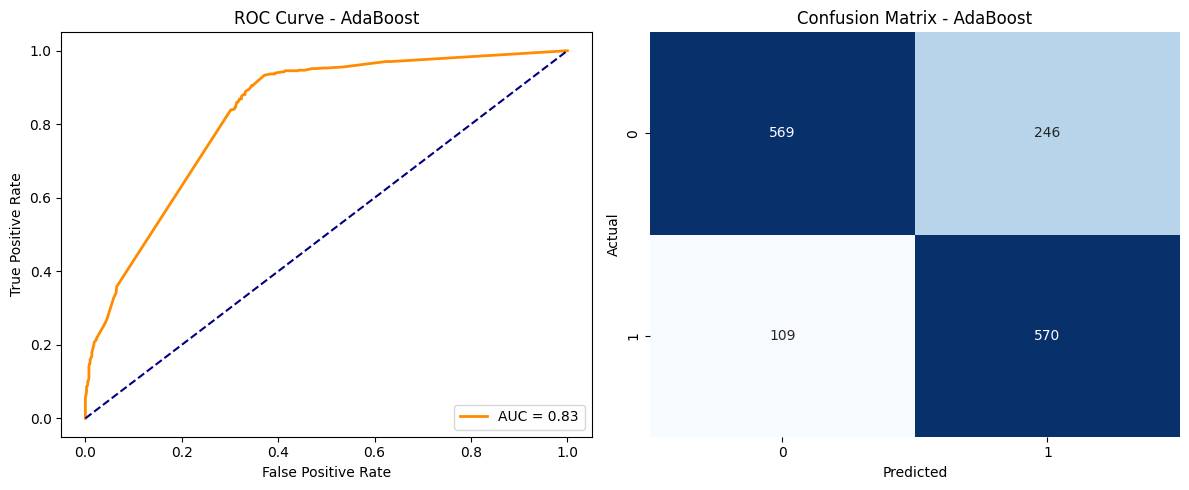

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
# ROC Curve & Confusion Matrix for AdaBoost
y_test_proba = ada_model.predict_proba(X_test)[:,1]  # probabilities of class=1
y_test_pred = ada_model.predict(X_test)

plt.figure(figsize=(12,5))

# 1. ROC Curve
plt.subplot(1,2,1)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost")
plt.legend(loc="lower right")

# 2. Confusion Matrix
plt.subplot(1,2,2)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - AdaBoost")

plt.tight_layout()
plt.show()


# Linear SVM using Cleaned Data

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Features & Target
X = df_cleaned.drop("Churn", axis=1)
y = df_cleaned["Churn"]

# Drop 'Phone Number' if present
X = X.drop("Phone Number", axis=1, errors="ignore")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize & Train Linear SVM
linear_svm_model = LinearSVC(random_state=42, dual=True, max_iter=5000)
linear_svm_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = linear_svm_model.predict(X_train_scaled)
y_test_pred = linear_svm_model.predict(X_test_scaled)

# Evaluation Function
def evaluate_model(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"--- {model_name} Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * (len(model_name) + 10))

# Evaluate Both
evaluate_model("Linear SVM - Train", y_train, y_train_pred)
evaluate_model("Linear SVM - Test", y_test, y_test_pred)


--- Linear SVM - Train Metrics ---
Accuracy: 0.7542
Precision: 0.6702
Recall: 0.8551
F1 Score: 0.7514
----------------------------
--- Linear SVM - Test Metrics ---
Accuracy: 0.7617
Precision: 0.6996
Recall: 0.8336
F1 Score: 0.7608
---------------------------


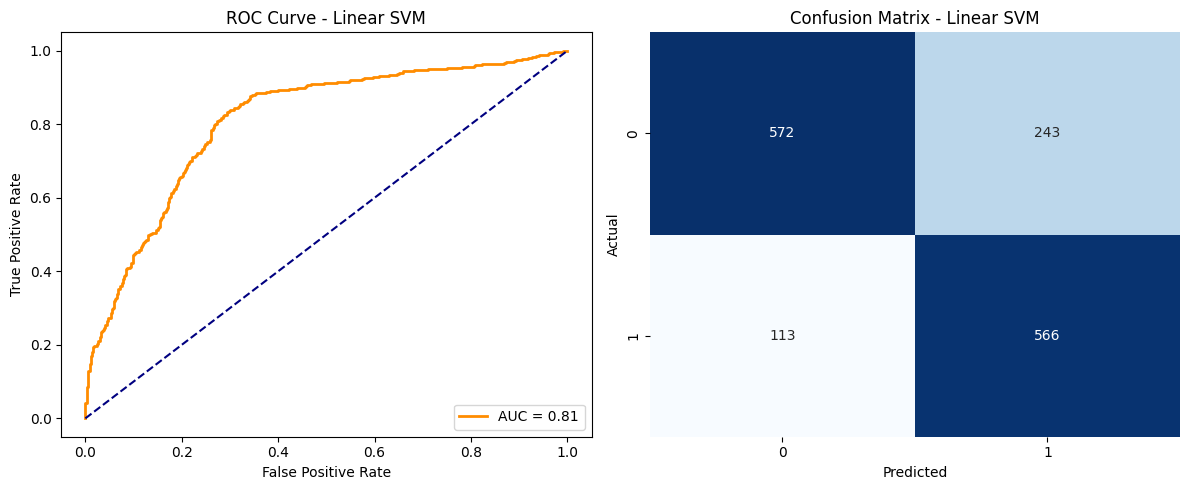

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ROC Curve & Confusion Matrix for Linear SVM
# Use decision_function for probability-like scores
y_test_scores = linear_svm_model.decision_function(X_test_scaled)
y_test_pred = linear_svm_model.predict(X_test_scaled)

plt.figure(figsize=(12,5))

# 1. ROC Curve
plt.subplot(1,2,1)
fpr, tpr, _ = roc_curve(y_test, y_test_scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Linear SVM")
plt.legend(loc="lower right")

# 2. Confusion Matrix
plt.subplot(1,2,2)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Linear SVM")

plt.tight_layout()
plt.show()


In [ ]:
# -----------------------------
# Gradio Theme
# -----------------------------
#'''custom_theme = gr.themes.Base()

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew, kurtosis
import gradio as gr
import plotly.express as px

# File Loader
def load_file(file):
    ext = os.path.splitext(file.name)[-1].lower()

    if ext in [".csv"]:
        return pd.read_csv(file.name)
    elif ext in [".xlsx", ".xls"]:
        return pd.read_excel(file.name)
    elif ext in [".json"]:
        try:
            return pd.read_json(file.name)
        except ValueError:
            with open(file.name, "r") as f:
                data = json.load(f)
            if isinstance(data, dict):
                return pd.DataFrame.from_dict(data)
            elif isinstance(data, list):
                return pd.DataFrame(data)
            else:
                raise ValueError("Unsupported JSON structure.")
    elif ext in [".parquet"]:
        return pd.read_parquet(file.name)
    elif ext in [".txt"]:
        try:
            return pd.read_csv(file.name, sep=None, engine="python")
        except Exception:
            return pd.read_csv(file.name, delimiter="\t")
    else:
        raise ValueError(f"Unsupported file type: {ext}")

# ML Processing Function
def process_file(file):
    df = load_file(file)

    phone_numbers = df["Phone Number"] if "Phone Number" in df.columns else None
    df = df.drop(columns=["Phone Number"], errors="ignore")

    # Encode categorical features
    for col in df.select_dtypes(include=['object']).columns:
        if col != "Churn":
            df[col] = LabelEncoder().fit_transform(df[col])

    if "Churn" in df.columns:
        X = df.drop("Churn", axis=1)
        y = df["Churn"]
    else:
        raise ValueError("File must contain 'Churn' column.")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "eta": 0.05,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }

    evals = [(dtrain, "train"), (dtest, "eval")]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predict probabilities
    y_proba = model.predict(xgb.DMatrix(X))

    def classify_customer(prob):
        if prob >= 0.7:
            return "Retainable"
        elif prob >= 0.4:
            return "Monitoring"
        else:
            return "Upsellable"

    df["Churn_Prob"] = y_proba
    df["Category"] = df["Churn_Prob"].apply(classify_customer)

    output_df = X.copy()
    if phone_numbers is not None:
        output_df.insert(0, "Phone Number", phone_numbers)
    output_df["Category"] = df["Category"]

    return output_df


# Offer Assignment Functions
def filter_loyalty(df):
    if "Account Length" in df.columns:
        return df[df["Category"] == "Upsellable"].sort_values(
            by="Account Length", ascending=False
        ).head(20)
    return pd.DataFrame({"Error": ["Account Length column missing"]})

def filter_daytime(df):
    if "Day Mins" in df.columns:
        return df[df["Category"] == "Upsellable"].sort_values(
            by="Day Mins", ascending=False
        ).head(20)
    return pd.DataFrame({"Error": ["Day Mins column missing"]})

def filter_nighttime(df):
    if "Night Mins" in df.columns:
        return df[df["Category"] == "Upsellable"].sort_values(
            by="Night Mins", ascending=False
        ).head(20)
    return pd.DataFrame({"Error": ["Night Mins column missing"]})

def filter_international(df):
    if "Intl Mins" in df.columns:
        return df[df["Category"] == "Upsellable"].sort_values(
            by="Intl Mins", ascending=False
        ).head(20)
    return pd.DataFrame({"Error": ["Intl Mins column missing"]})


# Update Tables + Pie Chart
def update_tables(file):
    try:
        df = process_file(file)
        hidden_df.value = df
        upsell_df = df[df["Category"] == "Upsellable"]
        monitor_df = df[df["Category"] == "Monitoring"]
        retain_df = df[df["Category"] == "Retainable"]

        category_counts = df["Category"].value_counts().reset_index()
        category_counts.columns = ["Category", "Count"]
        fig = px.pie(
            category_counts,
            names="Category",
            values="Count",
            color="Category",
            title="Customer Distribution",
            hole=0.3
        )

        return upsell_df, monitor_df, retain_df, df, fig

    except Exception as e:
        return (
            pd.DataFrame({"Error": [str(e)]}),
            pd.DataFrame(),
            pd.DataFrame(),
            pd.DataFrame(),
            px.scatter(title="Error")
        )


# Gradio UI
custom_theme = gr.themes.Soft(
    primary_hue="rose",
    secondary_hue="slate",
    font=["ui-sans-serif", "sans-serif"]
).set(
    body_background_fill="#121212",
    body_text_color="#FFFFFF",
    body_text_color_subdued="#BBBBBB",
    button_primary_background_fill="#4CAF50",
    button_primary_background_fill_hover="#388E3C",
    button_primary_text_color="#FFFFFF",
    block_background_fill="#1A1A1A",
    block_border_color="#333333",
    block_shadow="0px 4px 12px rgba(0,0,0,0.4)"
)


with gr.Blocks(theme=custom_theme) as demo:

    gr.Markdown("## Customer Upsell & Retention Classifier")

    file_input = gr.File(label=" Upload Customer Data", file_types=None)
    hidden_df = gr.State()

    with gr.Tabs():
        with gr.TabItem("Overview"):
            gr.Markdown("### Customer Category Distribution")
            pie_chart = gr.Plot()

        with gr.TabItem("Upsellable Customers"):
            upsell_table = gr.Dataframe()
            gr.Markdown("Recommended Offers for Upsellable Customers:")
            with gr.Row():
                btn_offer1 = gr.Button("Loyalty Premium Plan")
                btn_offer2 = gr.Button("Day Time Plan")
                btn_offer3 = gr.Button("Night Time Plan")
                btn_offer4 = gr.Button("International Plan")
            offer_table = gr.Dataframe()

            btn_offer1.click(filter_loyalty, inputs=hidden_df, outputs=offer_table)
            btn_offer2.click(filter_daytime, inputs=hidden_df, outputs=offer_table)
            btn_offer3.click(filter_nighttime, inputs=hidden_df, outputs=offer_table)
            btn_offer4.click(filter_international, inputs=hidden_df, outputs=offer_table)

        with gr.TabItem("Monitoring Customers"):
            monitor_table = gr.Dataframe()
            gr.Markdown("Recommended Offers for Monitoring Customers:")
            with gr.Row():
                btn_offer5 = gr.Button("Day Time Plan")
                btn_offer6 = gr.Button("Night Time Plan")
                btn_offer7 = gr.Button("International Plan")
            offer_table_mon = gr.Dataframe()

            btn_offer5.click(filter_daytime, inputs=hidden_df, outputs=offer_table_mon)
            btn_offer6.click(filter_nighttime, inputs=hidden_df, outputs=offer_table_mon)
            btn_offer7.click(filter_international, inputs=hidden_df, outputs=offer_table_mon)

        with gr.TabItem("Retainable Customers"):
            retain_table = gr.Dataframe()
            gr.Markdown("Recommended Offers for Retainable Customers:")
            with gr.Row():
                btn_offer8 = gr.Button("'1' Month Free Plan")
            # left as-is (no filtering logic change)

    file_input.change(
        update_tables,
        inputs=file_input,
        outputs=[upsell_table, monitor_table, retain_table, hidden_df, pie_chart]
    )

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d9107d4c69c38a61bb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
